In [1]:
#Creator: David Monheit
#Contact by email: dmmonheit@gmail.com

In [2]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install tqdm

You should consider upgrading via the 'C:\Users\dmmon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\dmmon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\dmmon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\dmmon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import math
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from matplotlib.colors import LinearSegmentedColormap

In [4]:
class ProcessData:
    # Constructor for initializing the ProcessData object with various attributes
    def __init__(self, pivot_date, threshold_percent, transaction_category, all_transactions, missing_data_path):
        self.pivot_date = pivot_date
        self.threshold_percent = threshold_percent
        self.transaction_category = transaction_category
        self.all_transactions = all_transactions
        self.missing_data_path = missing_data_path

        # Process data for periods before and after the pivot date
        self.cities_to_remove_before, self.spending_per_day_city_before, self.normalized_spending_before = self.process_period('before')
        self.cities_to_remove_after, self.spending_per_day_city_after, self.normalized_spending_after = self.process_period('after')

    # Filter transactions based on whether they occurred before or after the pivot date
    def filter_transactions(self, is_before):
        date_filter = '<' if is_before else '>='
        transactions = self.all_transactions.query(f'transaction_date {date_filter} @self.pivot_date')
        return transactions[transactions['internal_sub_code_desc'] == self.transaction_category]

    # Process transaction data for a specified period (before or after pivot date)
    def process_period(self, period):
        is_before = period == 'before'
        transactions = self.filter_transactions(is_before)
        cities_to_remove = self.identify_cities_to_remove(transactions, is_before)

        filtered_transactions = transactions[~transactions['Municipal_Authoritie'].isin(cities_to_remove)]
        spending_per_day_city_filtered = self.create_pivot_table(filtered_transactions, 'SUM', fill_zero=True)
        normalized_spending = self.normalize_data(spending_per_day_city_filtered)

        return cities_to_remove, spending_per_day_city_filtered, normalized_spending

    # Create a pivot table from transaction data
    def create_pivot_table(self, transactions, value_column, fill_zero=False):
        aggfunc = 'sum' if value_column == 'SUM' else 'count'
        pivot_table = transactions.pivot_table(values=value_column, index='transaction_date', columns='Municipal_Authoritie', aggfunc=aggfunc)
        if fill_zero:
            pivot_table = pivot_table.fillna(0)
        return pivot_table

    # Identify cities to be removed from analysis based on missing data
    def identify_cities_to_remove(self, transactions, is_before):
        count_per_day_city = self.create_pivot_table(transactions, 'COUNT')
        date_range = (transactions['transaction_date'].max() - transactions['transaction_date'].min()).days
        threshold_days = math.ceil(date_range * self.threshold_percent)
        cities_to_remove = count_per_day_city.columns[count_per_day_city.isna().sum() >= threshold_days]

        file_suffix = 'from_before' if is_before else 'from_after'
        filename = f'{self.missing_data_path}/missing_data_cities_{file_suffix}.txt'

        self.write_cities_to_file(cities_to_remove, filename)

        return cities_to_remove.tolist()

    # Normalize data for analysis
    def normalize_data(self, data):
        return (data - data.mean()) / data.std()

    # Write a list of cities to a file
    def write_cities_to_file(self, cities, filename):
        with open(filename, 'w', encoding='utf-8') as file:
            file.writelines(city + '\n' for city in cities)

    # Get processed data for the period before the pivot date
    def get_data_before(self):
        return self.spending_per_day_city_before, self.normalized_spending_before

    # Get processed data for the period after the pivot date
    def get_data_after(self):
        return self.spending_per_day_city_after, self.normalized_spending_after


In [14]:

# Function to calculate Pearson distance matrix from given data
def calculate_pearson_distance_matrix(data):
    correlation_matrix = data.corr()
    distance_matrix = 1 - correlation_matrix
    return pd.DataFrame(distance_matrix, index=data.columns, columns=data.columns)


# Function to reduce dimensionality using Isomap
def reduce_dimensionality_with_isomap(distance_matrix, n_components=2):
    isomap = Isomap(n_components=n_components, metric='precomputed')
    reduced_data = isomap.fit_transform(distance_matrix.values)
    reduced_df = pd.DataFrame(reduced_data, index=distance_matrix.index,
                              columns=[f'Component_{i + 1}' for i in range(n_components)])
    return reduced_df


# Function to plot reduced data
def plot_reduced_data(reduced_df, period, cities_to_plot=None):
    filtered_df = reduced_df if cities_to_plot is None else reduced_df.loc[cities_to_plot]
    plt.figure(figsize=(50, 50))
    plt.scatter(filtered_df['Component_1'], filtered_df['Component_2'])
    for i, point in filtered_df.iterrows():
        plt.text(point['Component_1'], point['Component_2'], str(i)[::-1])
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2D Representation of Selected Cities')
    plt.grid(True)

    plt.savefig(f'./output/data_plots/simple_data_from_{period}.png')

    plt.show()


# Function to perform DBSCAN clustering
def dbscan_clustering(coordinates, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
    return pd.Series(db.labels_, index=coordinates.index)

# function to find KNN
def find_nearest_neighbors(coordinates, outliers, n_neighbors=7):
    neighbors_model = NearestNeighbors(n_neighbors=n_neighbors + 1)
    neighbors_model.fit(coordinates)
    distances, indices = neighbors_model.kneighbors(outliers)

    nearest_neighbors_info = pd.DataFrame(index=outliers.index)
    for i in range(1, n_neighbors + 1):  # Start from 1 to skip the first neighbor (self)
        # Add neighbor names
        nearest_neighbors_info[f'Neighbor_{i}'] = coordinates.index[indices[:, i]]
        # Add corresponding distances
        nearest_neighbors_info[f'Distance_to_Neighbor_{i}'] = distances[:, i]

    return nearest_neighbors_info


# Function to plot clusters with annotations
def plot_clusters(coordinates, cluster_labels, period, labels=None):
    plt.figure(figsize=(40, 20))
    unique_labels = set(cluster_labels)
    custom_colors = ["#FF0000", "#00FF00", "#0000FF"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)
    colors = custom_cmap(np.linspace(0, 1, len(unique_labels)))
    for label, color in zip(unique_labels, colors):
        cluster_mask = (cluster_labels == label)
        cluster_points = coordinates[cluster_mask]
        plt.scatter(cluster_points.iloc[:, 0], cluster_points.iloc[:, 1],
                    color='black' if label == -1 else color, label=f'Cluster {label}', marker='o')
        if labels is not None:
            for idx, point in cluster_points.iterrows():
                if labels[idx]:
                    plt.annotate(labels[idx][::-1], (point[0], point[1]),
                                 textcoords="offset points", xytext=(0, 5), ha='center')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Clustering with Reversed Annotations')
    plt.legend()
    plt.grid(True)

    plt.savefig(f'./output/data_plots/clusters_from_{period}.png')
    plt.show()


# Function to plot all data with highlighted neighbors and lines
def plot_all_with_highlighted_neighbors_and_lines(reduced_df, outliers, nearest_neighbors, period):
    plt.figure(figsize=(50, 50))
    plt.scatter(reduced_df['Component_1'], reduced_df['Component_2'], color='lightgray', marker='o', zorder=1)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(outliers)))
    plotted_cities = set(outliers.index)
    for outlier, color in zip(outliers.index, colors):
        outlier_point = reduced_df.loc[outlier]
        plt.scatter(outlier_point['Component_1'], outlier_point['Component_2'],
                    color=color, s=200, marker='s', edgecolor='black', linewidth=2, zorder=3)
        plt.text(outlier_point['Component_1'], outlier_point['Component_2'], outlier[::-1],
                 fontsize=12, weight='bold', zorder=4)
        for neighbor in nearest_neighbors.loc[outlier]:
            if neighbor != outlier:
                neighbor_point = reduced_df.loc[neighbor]
                plt.plot([outlier_point['Component_1'], neighbor_point['Component_1']],
                         [outlier_point['Component_2'], neighbor_point['Component_2']],
                         color=color, linewidth=1, zorder=2)
                if neighbor not in plotted_cities:
                    plt.scatter(neighbor_point['Component_1'], neighbor_point['Component_2'],
                                color=color, s=50, marker='o', zorder=3)
                    plt.text(neighbor_point['Component_1'], neighbor_point['Component_2'], neighbor[::-1],
                             fontsize=10, zorder=4)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('All Cities with Highlighted Outliers, their Nearest Neighbors, and Connecting Lines')
    plt.grid(True)

    plt.savefig(f'./output/data_plots/all_data_with_neighbors_from_{period}.png')

    plt.show()

# function to plot each outlier time series with its KNN
def plot_outliers_time_series(outliers, nearest_neighbors, spending_per_day_city, period):
    base_dir = "./output/outliers/outlier_time_series"

    for outlier in outliers.index:
        # Get the time series for the outlier
        outlier_series = spending_per_day_city[outlier]

        # Start a new plot for the outlier
        plt.figure(figsize=(12, 6))
        outlier_series.plot(label=f'Outlier - {outlier[::-1]}', linewidth=2, marker='o')

        # Plot the time series for each neighbor
        for neighbor in nearest_neighbors.loc[outlier]:
            if neighbor != outlier:  # Avoid plotting the outlier itself as a neighbor
                if neighbor in spending_per_day_city.columns:
                    neighbor_series = spending_per_day_city[neighbor]
                    neighbor_series.plot(label=f'Neighbor - {neighbor[::-1]}', linewidth=1, linestyle='--')

        # Add title, legend, and labels
        plt.title(f'Time Series for Outlier {outlier[::-1]} and its Nearest Neighbors')
        plt.xlabel('Date')
        plt.ylabel('Transaction Value')
        plt.legend()

        # Construct the file path
        file_path = os.path.join(base_dir, f'{outlier}_from_{period}_timeseries.png')

        plt.savefig(file_path)

# function to run the analysis
def run_analysis(normalized_spending, period, spending_per_day_city, eps_value):
    # Calculate Pearson distance matrix and reduce dimensionality
    pearson_distance_df = calculate_pearson_distance_matrix(normalized_spending)
    reduced_df = reduce_dimensionality_with_isomap(pearson_distance_df)

    # DBSCAN Clustering
    min_samples_value = 7
    cluster_labels = dbscan_clustering(reduced_df, eps=eps_value, min_samples=min_samples_value)

    # Identify outliers
    outliers = reduced_df[cluster_labels == -1]

    # Find Nearest Neighbors for Outliers
    nearest_neighbors = find_nearest_neighbors(reduced_df, outliers)

    outliers_with_neighbors = pd.DataFrame(index=outliers.index)
    for i in range(1, 8):  # Adjust the range as needed
        # Round the distances to 1 decimal place
        rounded_distances = nearest_neighbors[f'Distance_to_Neighbor_{i}'].round(1)
        # Combine neighbor names with rounded distances
        outliers_with_neighbors[f'Neighbor {i}'] = nearest_neighbors[f'Neighbor_{i}'] + ' (' + rounded_distances.astype(
            str) + ')'
    # Save the combined data to CSV
    outliers_with_neighbors.to_csv(f'./output/outliers/outliers_with_neighbors_from_{period}.csv', encoding='utf-8-sig')

    # Create a series to hold labels for plotting
    all_labels = pd.Series([''] * len(reduced_df), index=reduced_df.index)
    all_labels[outliers.index] = outliers.index

    # Select only the neighbor name columns for the plotting function
    neighbor_names_only = nearest_neighbors[
        [f'Neighbor_{i}' for i in range(1, 4)]]  # Adjusted to match the number of neighbors

    # plot
    plot_reduced_data(reduced_df, period=period)
    plot_clusters(reduced_df, cluster_labels, labels=all_labels, period=period)
    plot_all_with_highlighted_neighbors_and_lines(reduced_df, outliers, neighbor_names_only, period=period)
    plot_outliers_time_series(outliers, nearest_neighbors, spending_per_day_city, period=period)
    outliers = reduced_df[cluster_labels == -1]

    # Return the outlier cities
    return outliers.index.tolist()



In [6]:
# ensure all paths used exist
def ensure_paths(series_plots, missing_data, data_plots):
    os.makedirs(series_plots, exist_ok=True)
    os.makedirs(missing_data, exist_ok=True)
    os.makedirs(data_plots, exist_ok=True)

Analysis for data before the pivot date:


Municipal_Authoritie,אבו גוש,אבו סנאן,אבן יהודה,אום אל פחאם,אופקים,אור יהודה,אור עקיבא,אורנית,אזור,אילת,...,שומרון,שלומי,שעב,שער הנגב,שפיר,שפרעם,תל אביב - יפו,תל מונד,תל שבע,תמר
Municipal_Authoritie,,,,,,,,,,,,,,,,,,,,,
אבו גוש,0.000000,0.757539,0.527110,0.577069,1.220340,1.235403,1.186973,1.005679,1.326060,1.217413,...,0.751386,1.238910,0.699507,1.022791,1.026239,0.097336,1.014204,1.097464,0.915974,0.868437
אבו סנאן,0.757539,0.000000,1.007029,0.790677,1.170508,1.166996,1.142513,1.117569,1.130283,1.103364,...,1.023762,0.996744,0.994700,1.035273,1.052370,0.603068,1.108790,1.186349,0.651756,0.989918
אבן יהודה,0.527110,1.007029,0.000000,1.404635,0.353818,0.354549,0.297790,0.177335,0.444044,0.312019,...,0.118900,0.362976,0.745401,0.251290,0.249124,0.733719,0.163943,0.228667,1.158046,0.410611
אום אל פחאם,0.577069,0.790677,1.404635,0.000000,1.657925,1.680478,1.670763,1.659318,1.628956,1.672030,...,1.472214,1.677478,0.941703,1.580353,1.568150,0.423019,1.645326,1.677682,0.631268,1.333178
אופקים,1.220340,1.170508,0.353818,1.657925,0.000000,0.008577,0.014437,0.136637,0.260485,0.063793,...,0.244332,0.086061,1.003552,0.211045,0.243355,1.356136,0.068269,0.062453,1.347802,0.523345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
שפרעם,0.097336,0.603068,0.733719,0.423019,1.356136,1.371956,1.330801,1.177985,1.433593,1.370615,...,0.888733,1.377859,0.756638,1.192385,1.131290,0.000000,1.199906,1.262431,0.781786,0.966578
תל אביב - יפו,1.014204,1.108790,0.163943,1.645326,0.068269,0.074080,0.044909,0.051758,0.200664,0.050362,...,0.133091,0.099360,0.907644,0.102534,0.142702,1.199906,0.000000,0.038242,1.265302,0.433851
תל מונד,1.097464,1.186349,0.228667,1.677682,0.062453,0.057162,0.038051,0.035725,0.215816,0.083580,...,0.170798,0.123414,0.950192,0.154672,0.170316,1.262431,0.038242,0.000000,1.310994,0.482891


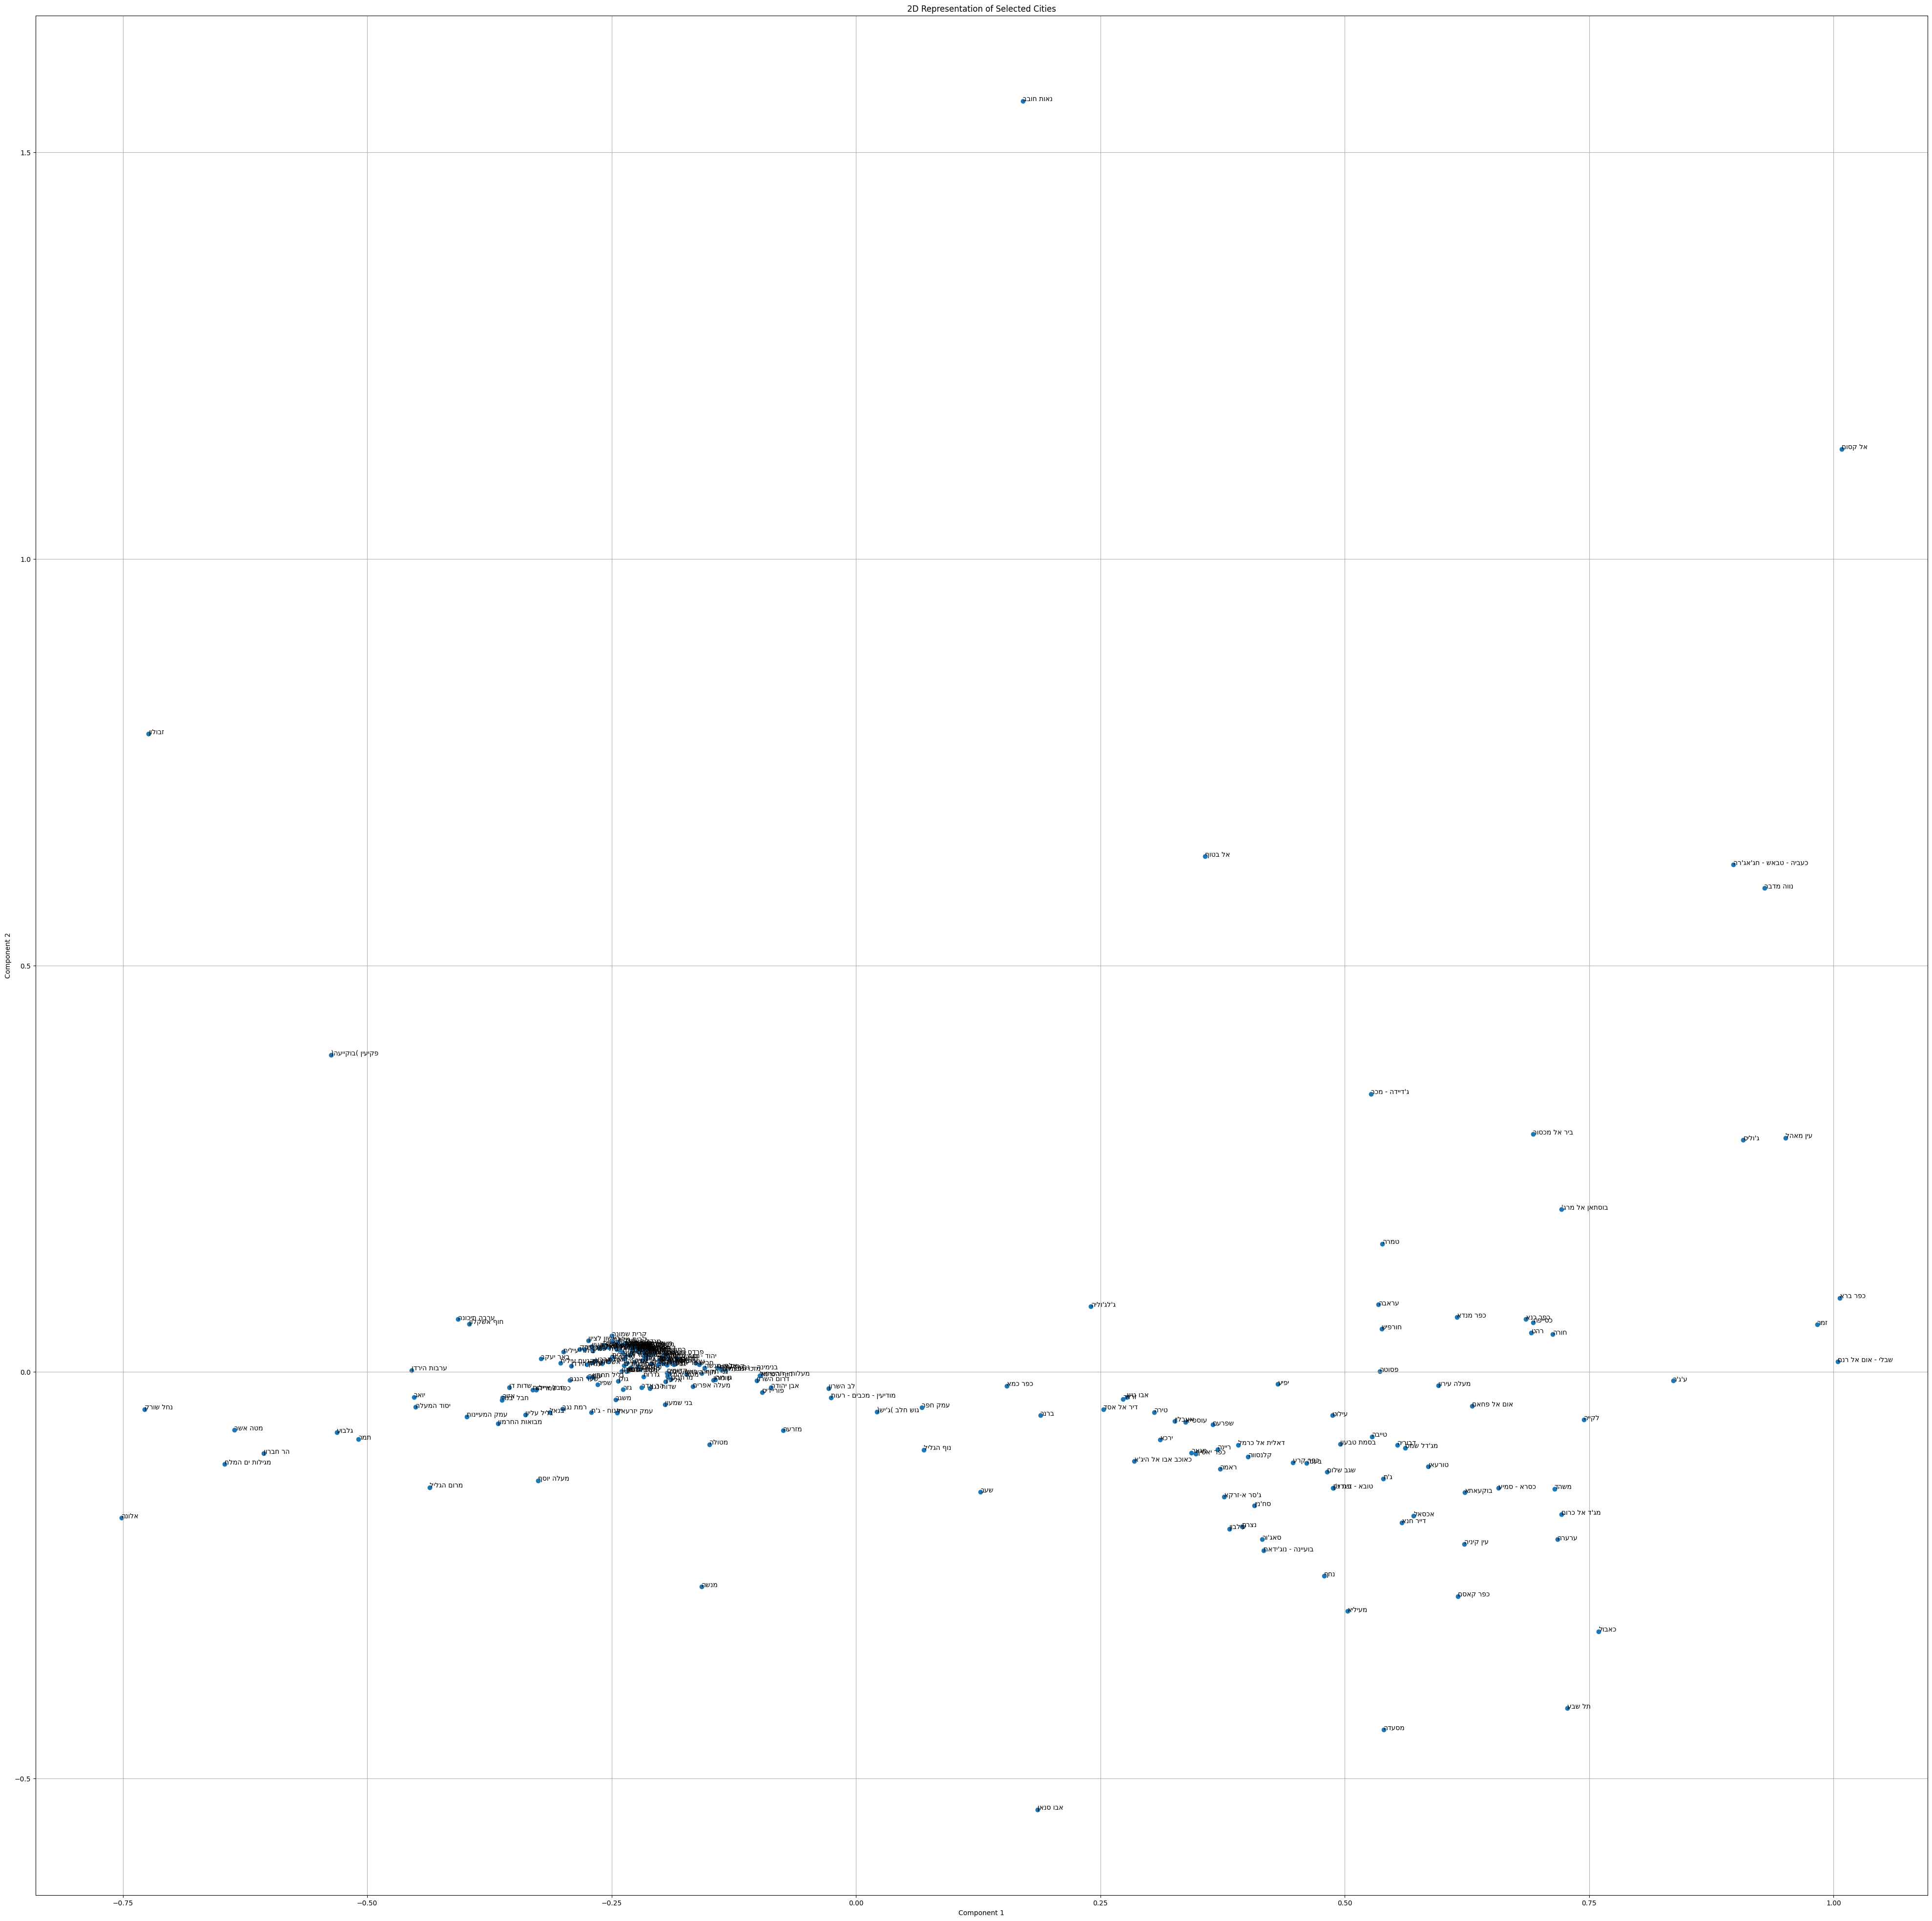

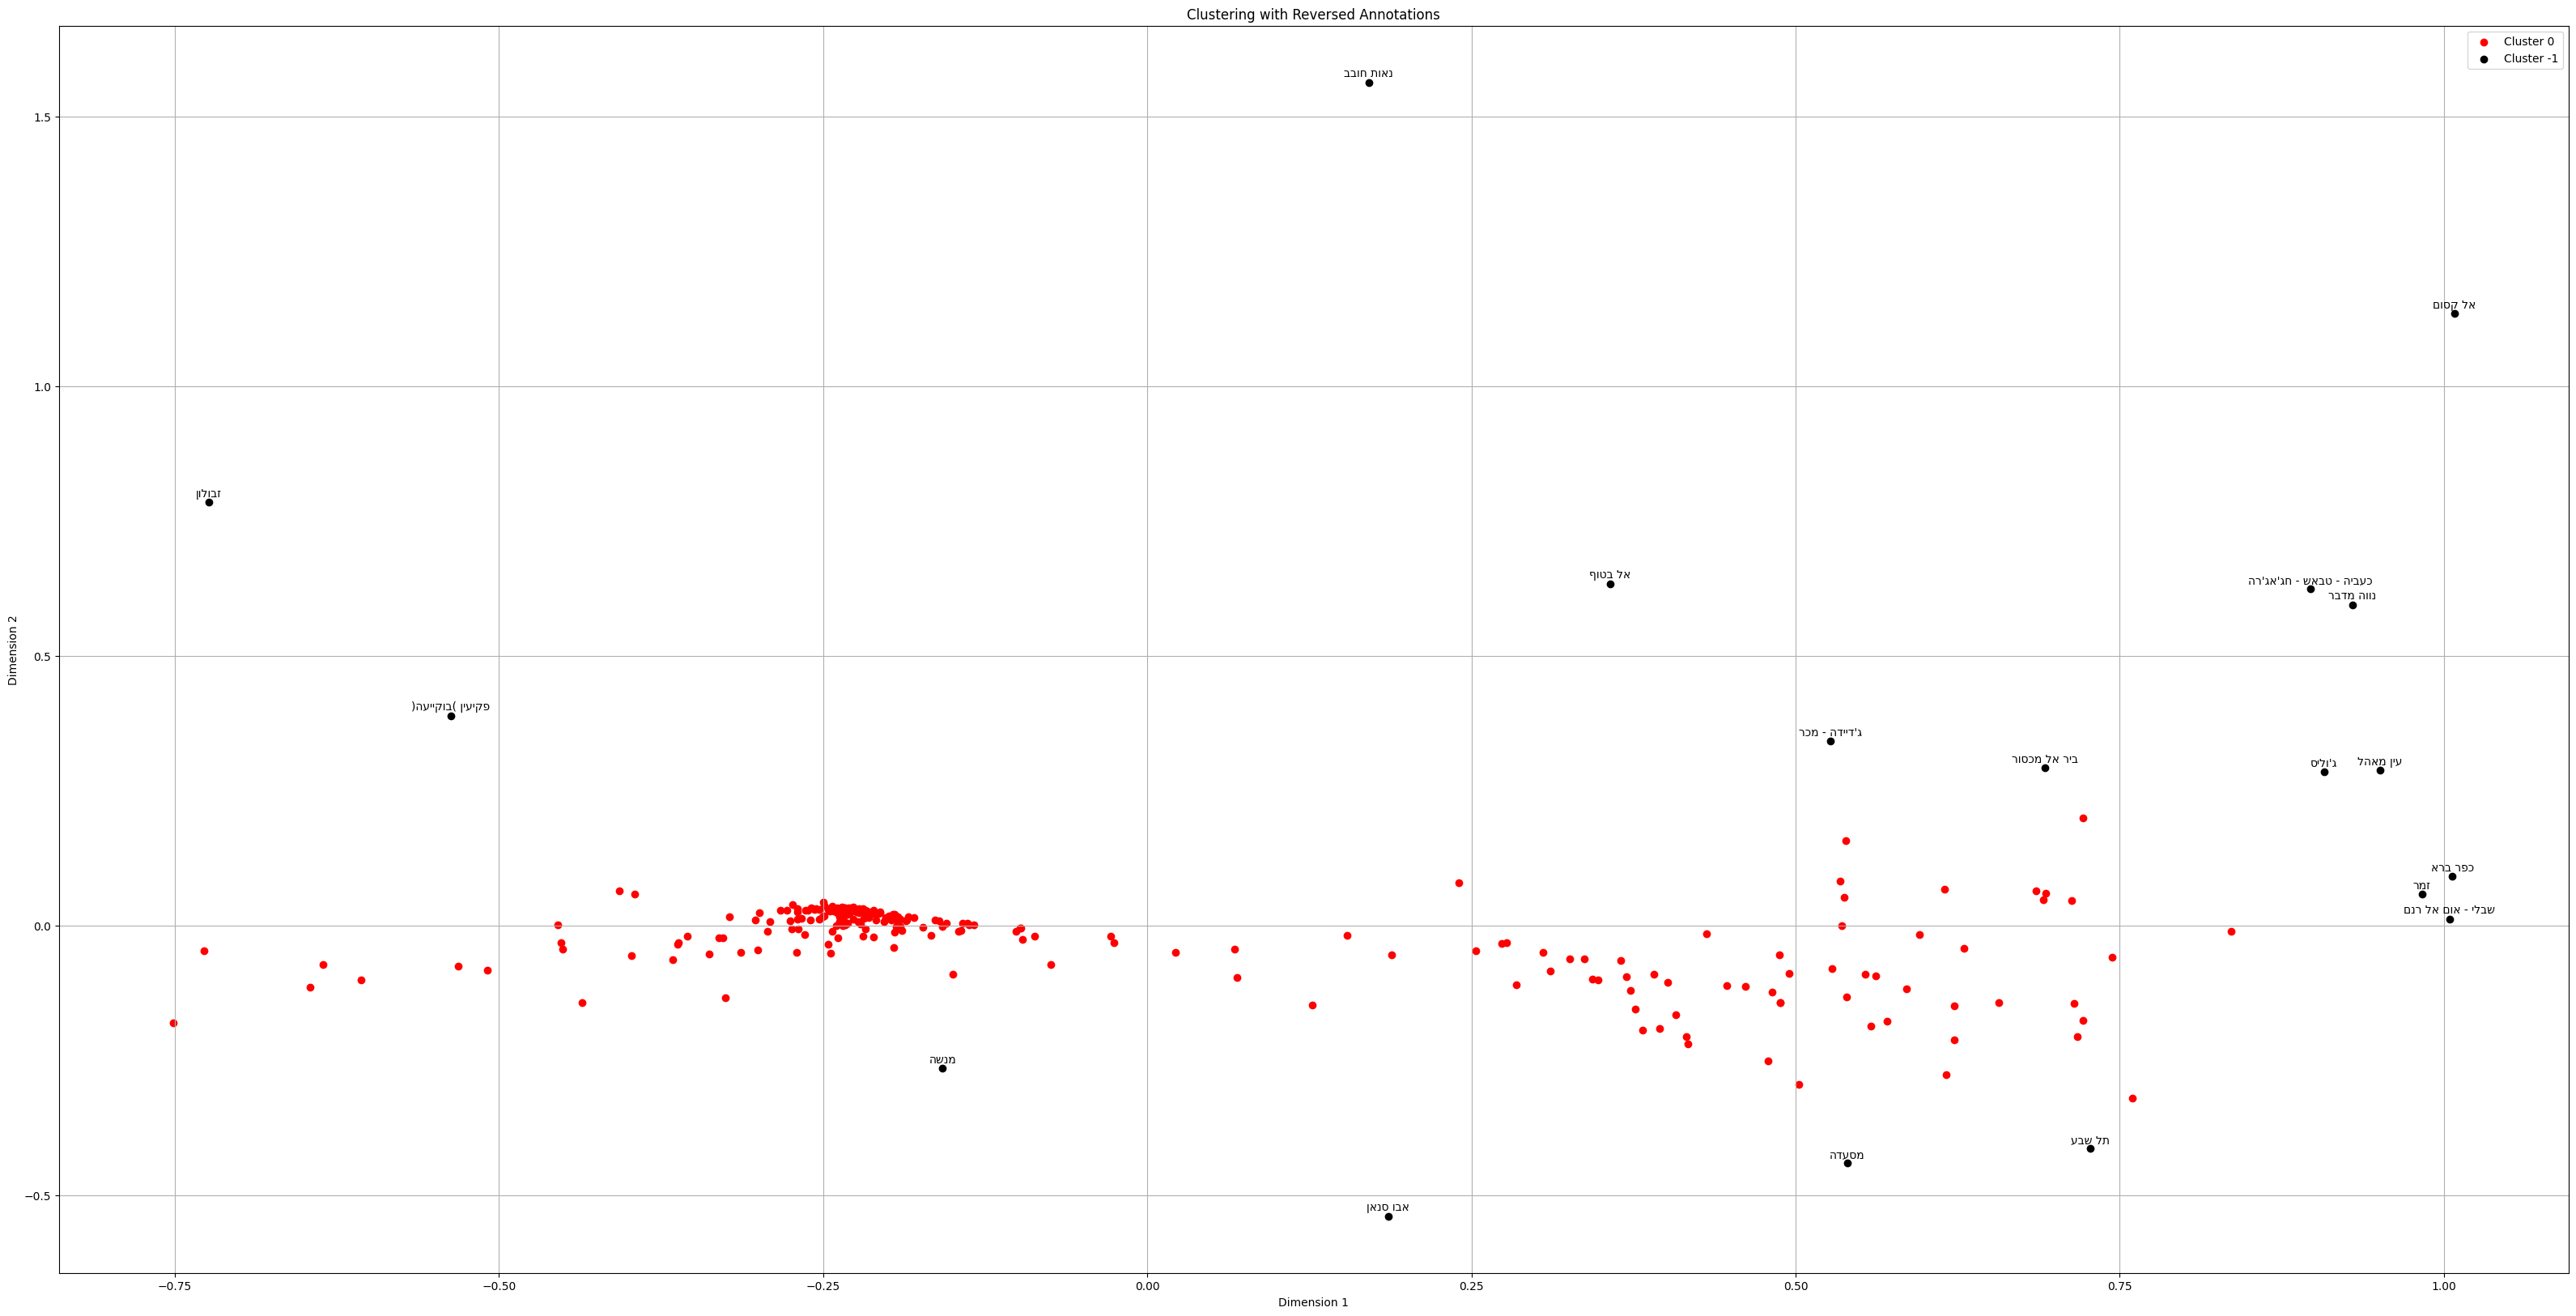

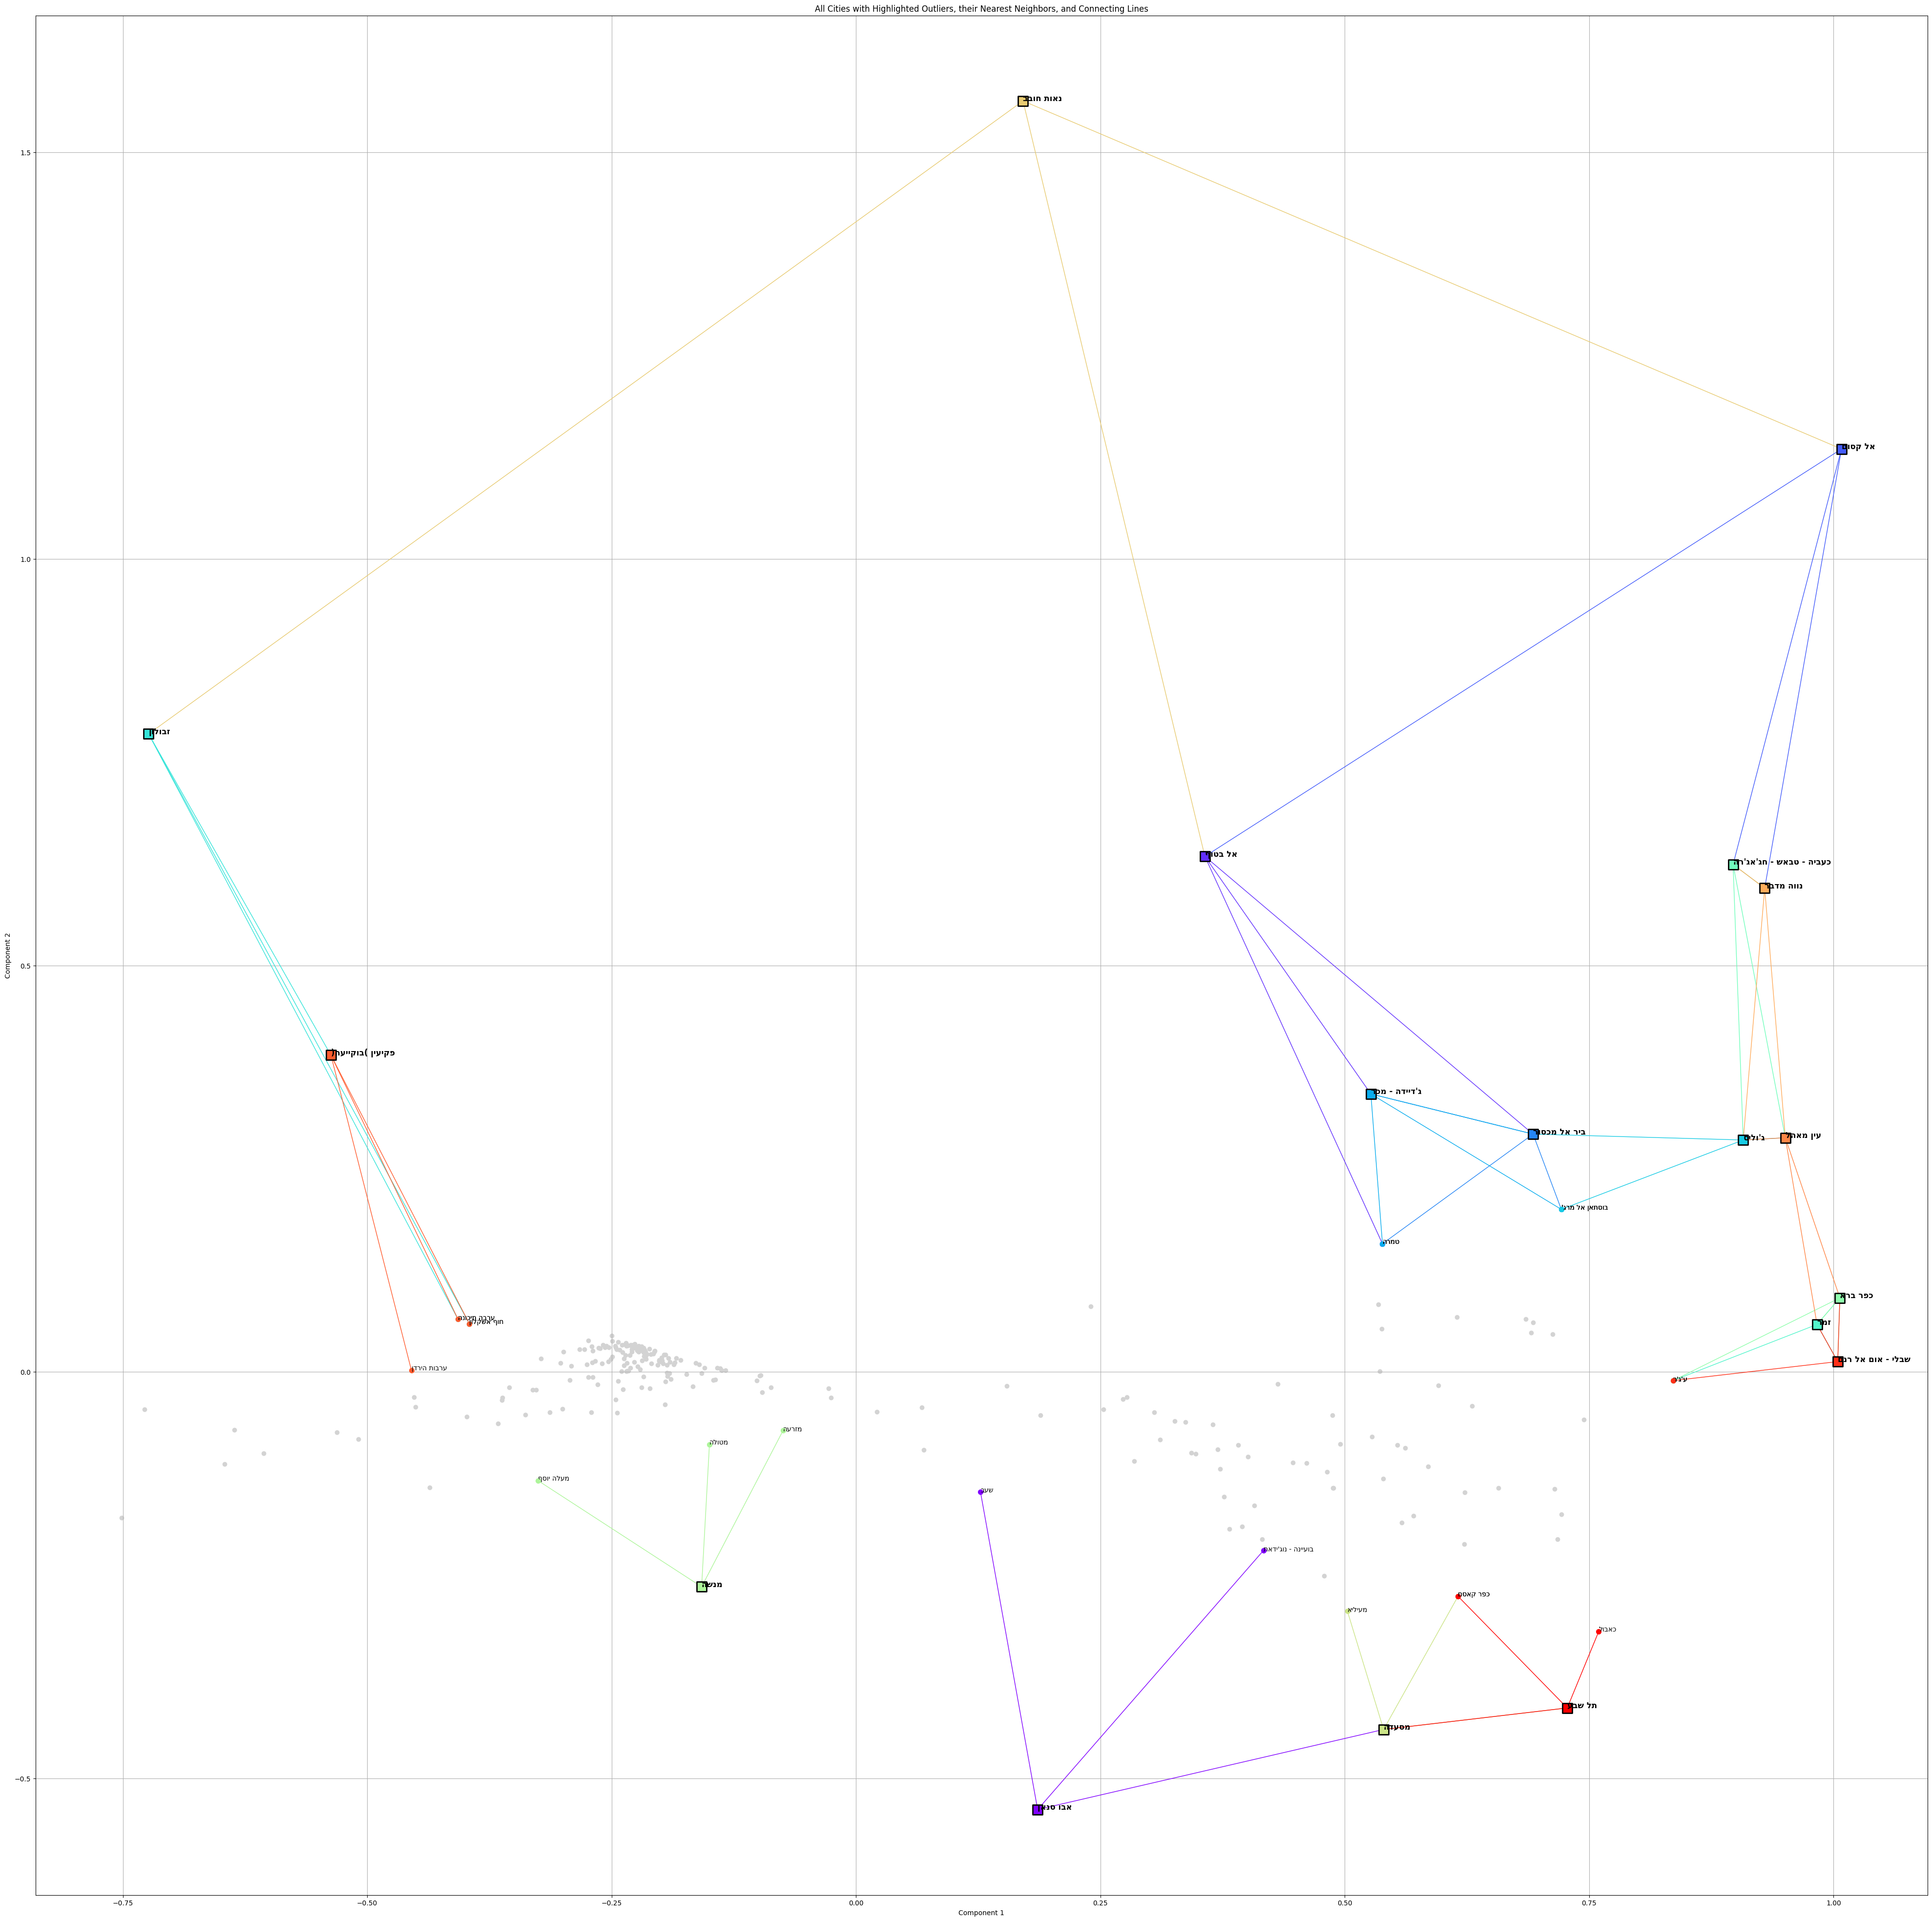

KeyboardInterrupt: 

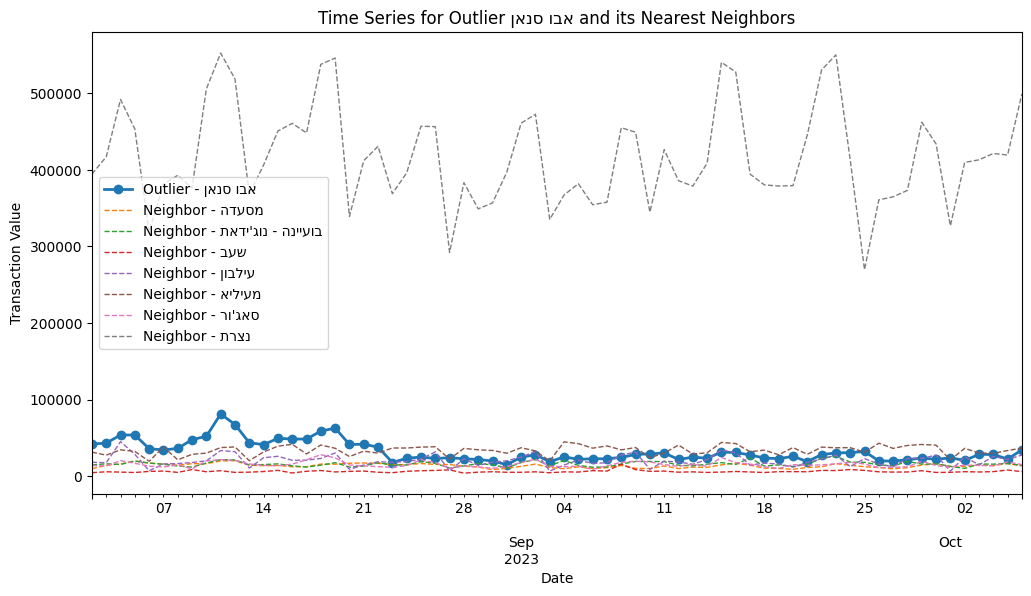

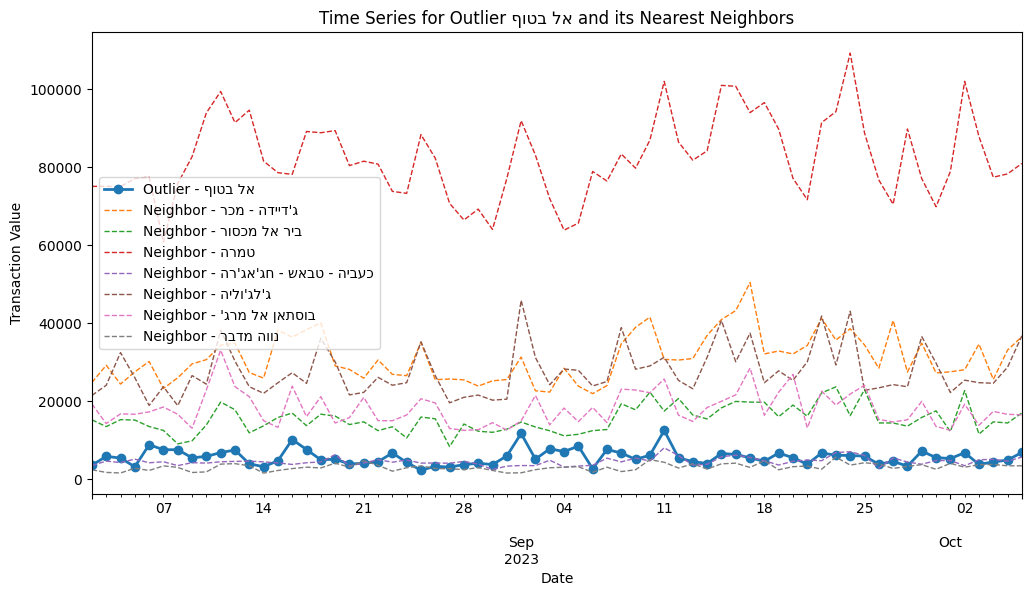

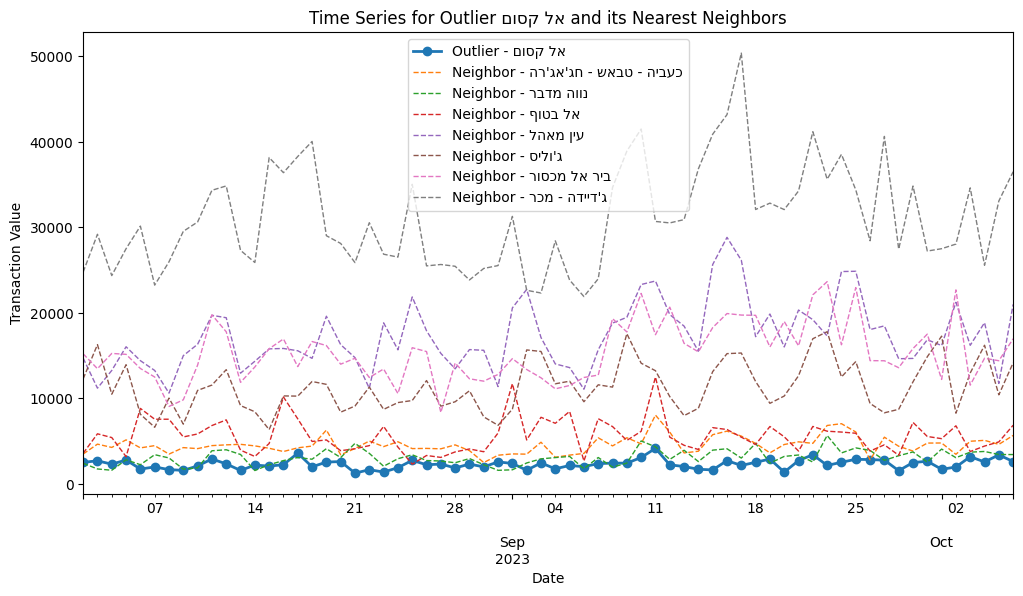

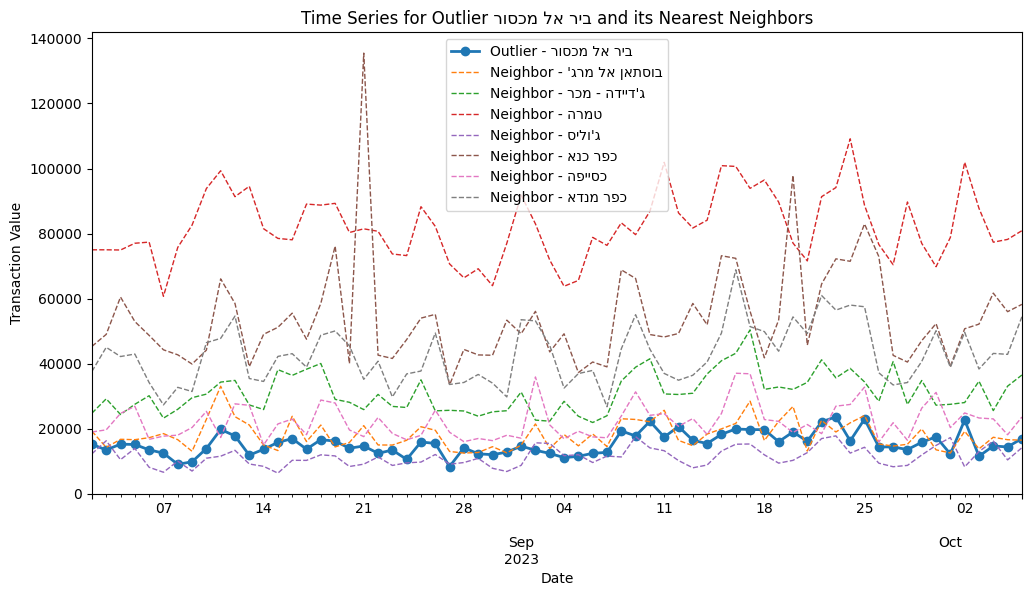

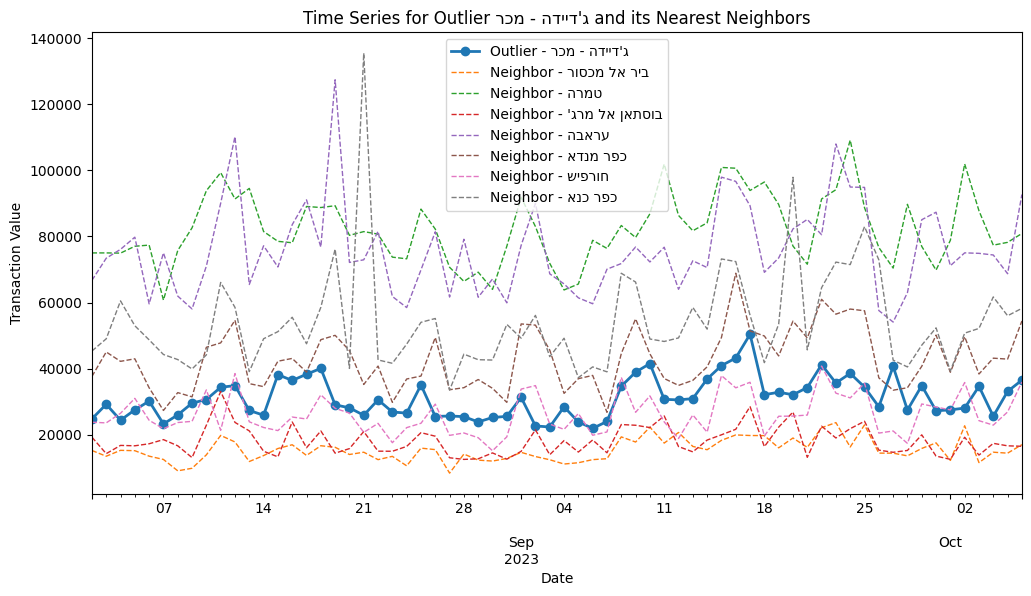

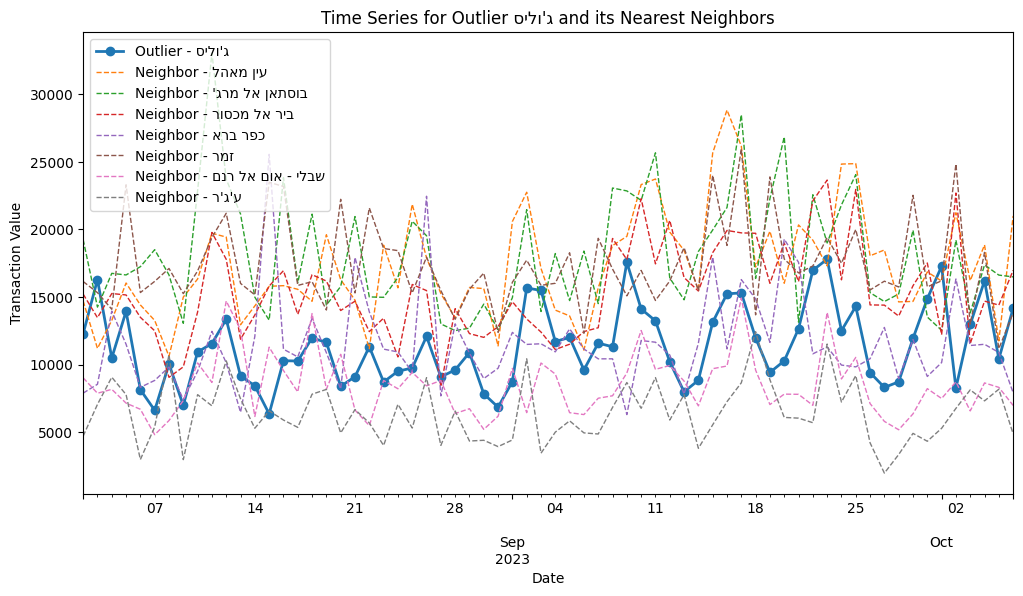

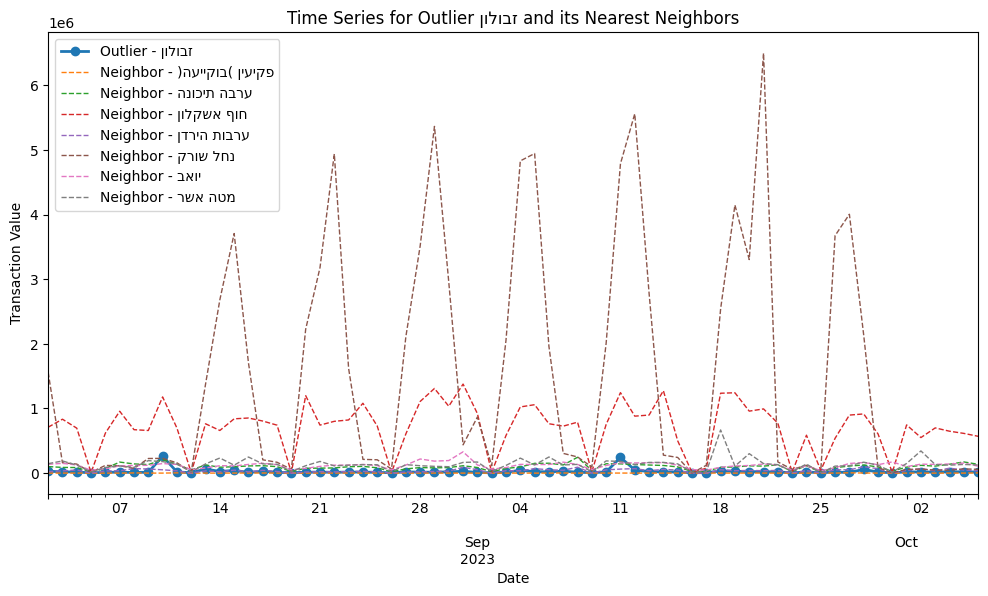

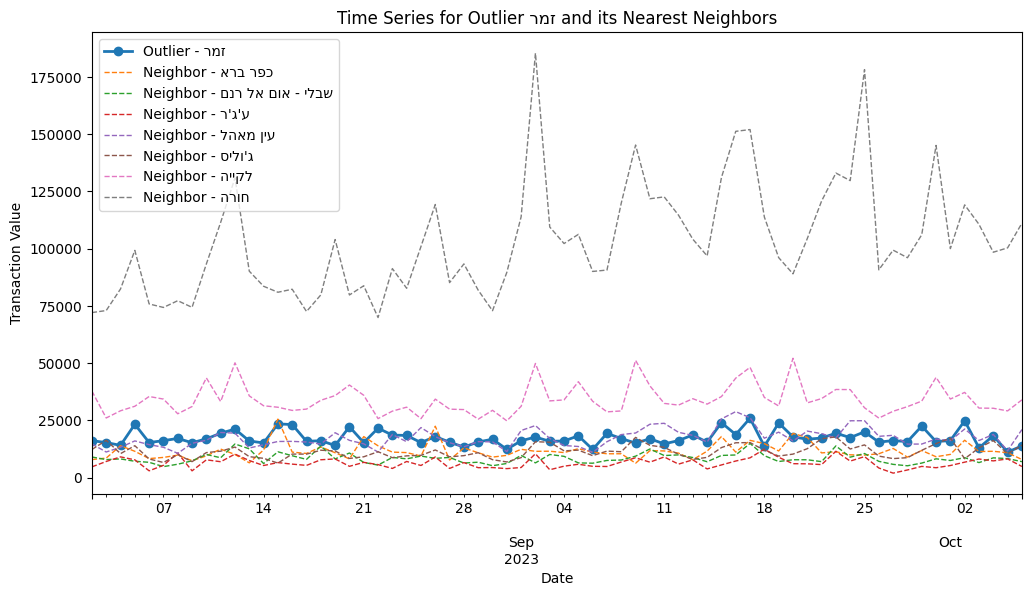

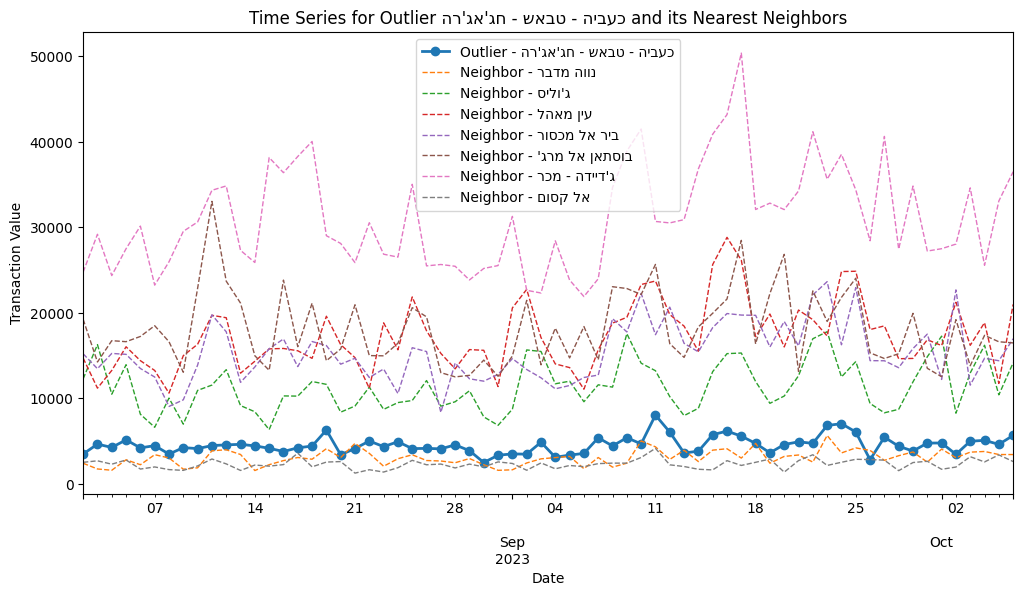

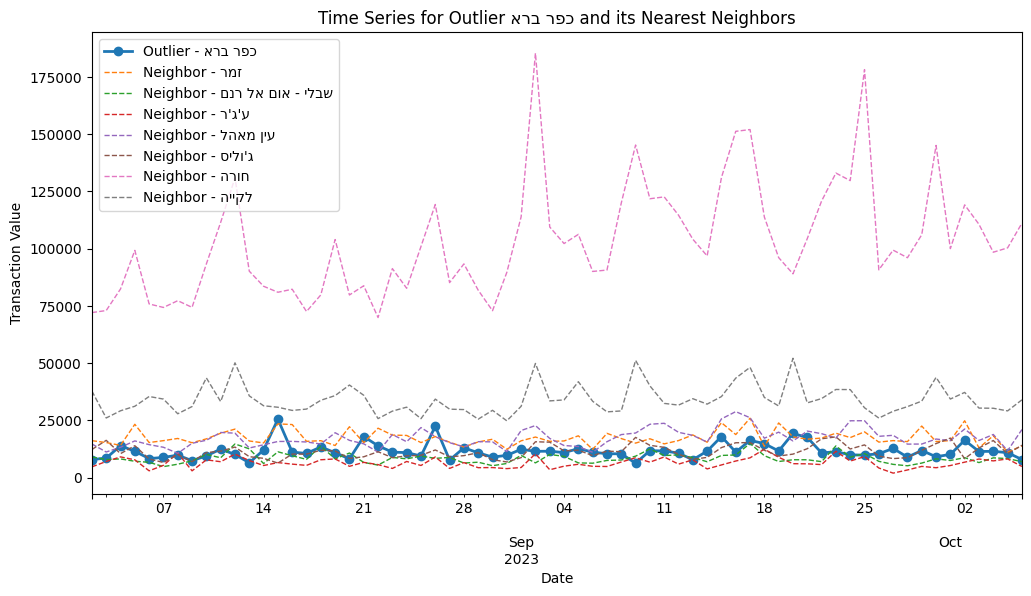

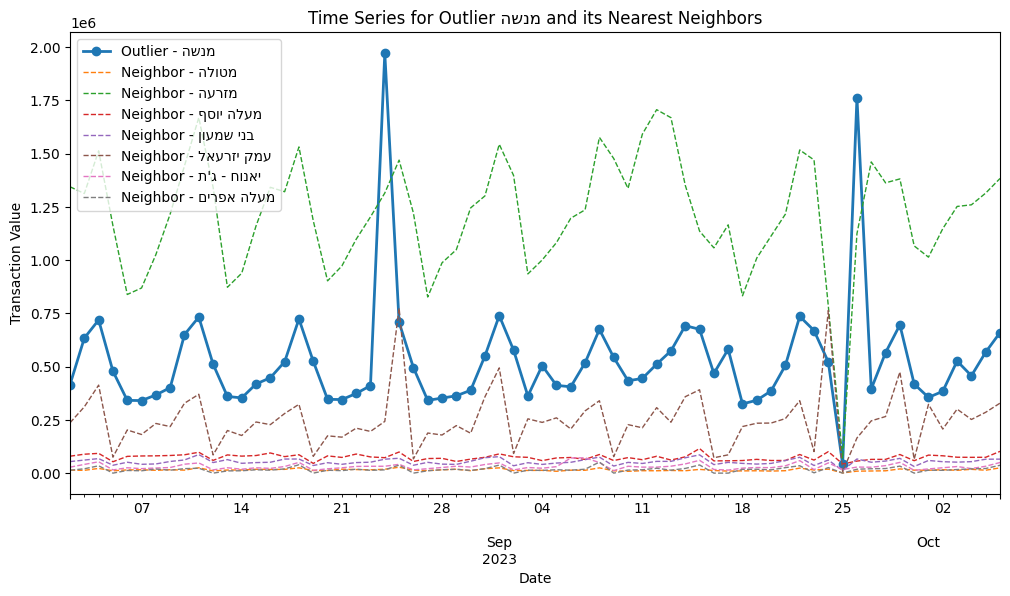

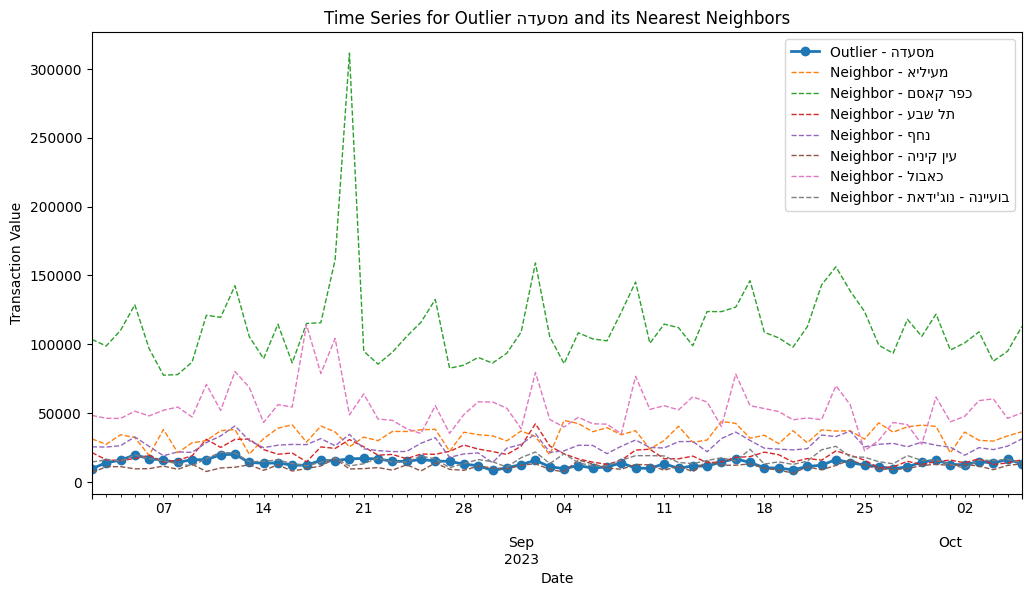

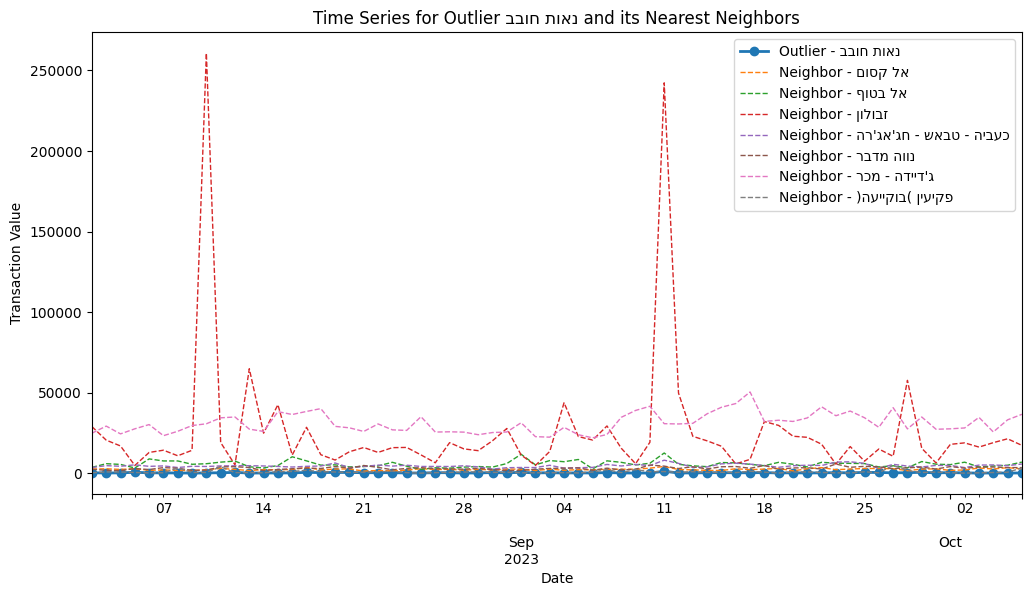

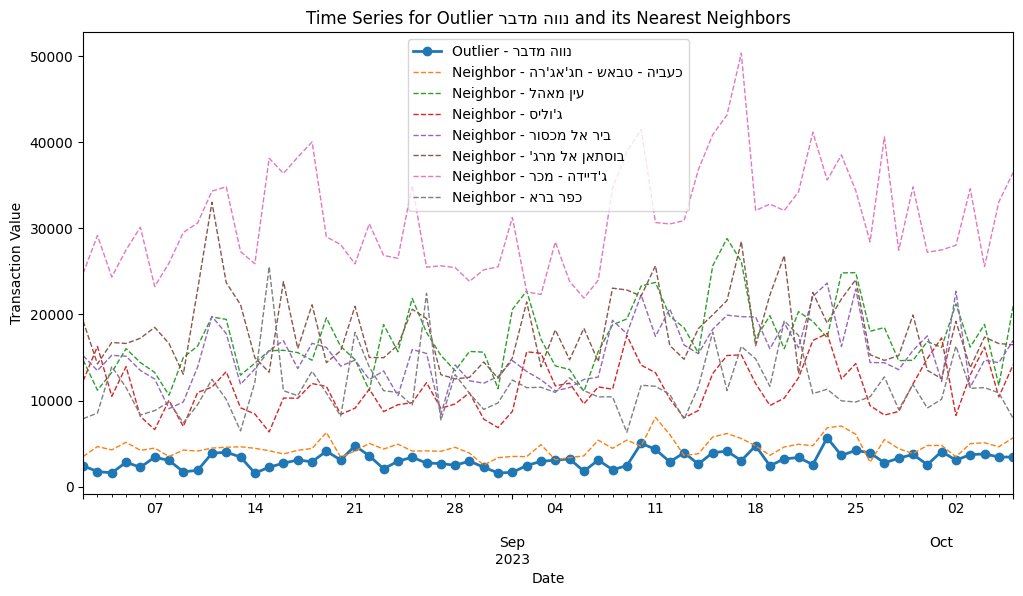

In [15]:
pivot_date = '2023-10-7'  # parameter, to compare before and after
missing_threshold_percent = 0.19  # parameter, percent of acceptable missing data
clustering_threshold = 0.15  # parameter, clustering sensitivity
transaction_category = 'רשתות מזון  סופרמרקטים ומרכולים'  # parameter, for category
data_path = "./all_transaction.csv"  # parameter, the data
series_plots_path = "./output/outliers/outlier_time_series"
missing_data_path = "./output/missing_data_cities"
data_plots_path = "./output/data_plots"
unique_outliers_path = "./output/outliers/unique_outliers.txt"
already_existing_outliers_path = "./output/outliers/already_existing_outliers.txt"


def main():
    ensure_paths(series_plots_path, missing_data_path, data_plots_path)
    all_transactions = pd.read_csv(data_path, index_col='Unnamed: 0')
    all_transactions = all_transactions.dropna(subset=['SETL_NAME', 'internal_code_desc'])
    all_transactions['transaction_date'] = pd.to_datetime(all_transactions.transaction_date)
    all_transactions['Card_Present'] = all_transactions.Card_Present.replace({'No': 'Online', 'Yes': 'Locally'})

    # Initialize ProcessData object
    my_data = ProcessData(pivot_date, missing_threshold_percent, transaction_category, all_transactions,
                          missing_data_path)

    # Analyze data before and after the pivot date
    spending_per_day_city_before, normalized_spending_before = my_data.get_data_before()
    print("Analysis for data before the pivot date:")
    outliers_before = run_analysis(normalized_spending_before, 'before', spending_per_day_city_before,
                                   clustering_threshold)

    spending_per_day_city_after, normalized_spending_after = my_data.get_data_after()
    print("Analysis for data after the pivot date:")
    outliers_after = run_analysis(normalized_spending_after, 'after', spending_per_day_city_after, clustering_threshold)

    # Find unique and already existing outliers
    outliers_before_set = set(outliers_before)
    outliers_after_set = set(outliers_after)
    unique_outliers_after = outliers_after_set - outliers_before_set
    already_existing_outliers = outliers_after_set & outliers_before_set

    print("Unique outliers after the pivot date:", unique_outliers_after)
    print("Already existing outliers:", already_existing_outliers)

    # Write outliers to files
    write_outliers_to_file(unique_outliers_after, unique_outliers_path)
    write_outliers_to_file(already_existing_outliers, already_existing_outliers_path)


# Function to write outliers to a file
def write_outliers_to_file(outliers, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        for outlier in sorted(outliers):
            file.write(outlier + '\n')


if __name__ == "__main__":
    main()